In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.datasets import get_data_home
import sklearn
from torchsummary import summary

print(get_data_home())
sklearn.__version__

C:\Users\ksetd\scikit_learn_data


'1.0.1'

In [3]:
from sklearn.datasets import get_data_home
print(get_data_home())

C:\Users\ksetd\scikit_learn_data


In [4]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(data_home = '.', min_faces_per_person=0, resize=0.5, color=True,
                              slice_=(slice(94, 190, None), slice(78, 174, None)), download_if_missing=True)

In [5]:
from sklearn.model_selection import train_test_split

X = lfw_people.images
X = np.moveaxis(X, 3, 1)
IMG_SHAPE = X.shape[1:]

X = X.astype('float32') / 255.0
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [6]:
dimenstion = X_train.shape[1:]

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
EPOCHS = 40

cuda


In [8]:
from IPython import display  # выводить график обучения в онлайн режиме
from tqdm.auto import tqdm
import os

этот кусок не работает

In [16]:
# # Train your autoencoder
# # Visualize progress in reconstruction and loss decay

# def train(model, train_loader, val_loader, device=DEVICE, epochs=EPOCHS, path=''):

#     train_loss = torch.tensor([0,0])
#     val_loss = torch.tensor([0,0])
#     train_loss_epoch = torch.tensor([0,0])
#     val_loss_epoch = torch.tensor([0,0])

#     for epoch in tqdm(range(epochs)):
#         model.train()
#         for X in train_loader:
#             batch = X[0].to(device)  # [0] is needed due to X being a list
#             reconstruction, _ = model(batch)
#             loss = criterion(reconstruction, batch)
#             loss.backward()

#             optimizer.step()
#             optimizer.zero_grad()

#             train_loss.append(loss.detach().cpu().numpy())
        
#         model.eval()
#         with torch.no_grad():
#             for X in val_loader:
#                 batch = X[0].to(device)  # [0] is needed due to X being a list
#                 reconstruction, _ = model(batch)

#                 loss = criterion(reconstruction, batch)
#                 val_loss.append(loss.cpu().numpy())

#         train_loss_epoch.append(np.mean(train_loss))
#         val_loss_epoch.append(np.mean(val_loss))

#         if epoch % 5 == 0:
#             print(
#                 f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f};   "
#                 f"val loss: {val_loss_epoch[-1]:.6f}")

#         os.makedirs(path, exist_ok=True)
#         torch.save(model.state_dict(), path + '/checkpoint.pt')

#         train_loss_epoch = train_loss_epoch.to(device)
#         val_loss_epoch = val_loss_epoch.to(device)

#     return model, train_loss_epoch, val_loss_epoch

этот кусок работает

In [17]:
def train(model, train_loader, val_loader, device=DEVICE, epochs=EPOCHS, path=''):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X in train_loader:
            batch = X[0].to(device)  # [0] is needed due to X being a list
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())
        
        model.eval()
        with torch.no_grad():
            for X in val_loader:
                batch = X[0].to(device)  # [0] is needed due to X being a list
                reconstruction, _ = model(batch)

                loss = criterion(reconstruction, batch)
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

        if epoch % 5 == 0:
            print(
                f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f};   "
                f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')

    return model, train_loss_epoch, val_loss_epoch

In [107]:
class PrintSize(nn.Module):
    def __init__(self):
        super(PrintSize, self).__init__()

def forward(self, x):
    print(x.shape)
    return x

In [124]:
class CNNAutoencoder(nn.Module):

    def __init__(self, img_shape):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()
        
        def initialization(layer):
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform(layer.weight)
                layer.bias.data.fill_(0.)
    


        self.encoder = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # (48-3+1*2)/1+1 = 48
            nn.ELU(),
            nn.MaxPool2d(2), # (48-2+0)/2+1 = 24
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (24-3+1*2)/1+1 = 24
            nn.ELU(),
            nn.MaxPool2d(2), # (24-2+0)/2+1 = 12
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # (12-3+1*2)/1+1 = 12
            nn.ELU(), 
            nn.MaxPool2d(2), # (12-2+0)/2+1 = 6
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1), # (6-3+0)/1+1 = 4
            nn.ELU(), 
            nn.AdaptiveMaxPool2d(1), # (4-4+0)/2+1 = 1
            nn.Flatten(),
            nn.Linear(256, 150)
            )

        self.decoder = nn.Sequential(nn.Linear(150, 150*4),
                                     nn.ReLU(),
                                     nn.Linear(150*4, 3*48*48))
        
        # self.decoder = nn.Sequential(PrintSize(),
        #                             nn.Unflatten(150, (1, 1, 150)),
        #                              nn.ConvTranspose2d(150,150, 3),
        #                              nn.ELU(),
        #                              nn.Upsample(scale_factor=2, mode='bilinear'),
        #                              nn.ConvTranspose2d(150,64, 3),
        #                              nn.ELU(),
        #                              nn.Linear(150*4, 3*48*48))
        
        self.apply(initialization)
        
    def forward(self, x):
        # print(x.shape, 'init')
        # x = torch.flatten(x, start_dim=0, end_dim=1)
        init_shape = x.shape
        # print(x.shape, 'reshaped')

        latent_code = self.encoder(x)
        # print(latent_code.shape, 'latent code')
        reconstruction = self.decoder(latent_code)
        # print(reconstruction.shape, 'reconstructed')
        reconstruction = reconstruction.reshape(init_shape)
        
        # return latent_code
        return reconstruction, latent_code

    

In [125]:
autoencodercnn4 = CNNAutoencoder(dimenstion)
autoencodercnn4 = autoencodercnn4.to(DEVICE)

In [126]:
criterion = torch.nn.MSELoss()

print('input_shape', dimenstion)

# Use Adam optimizer
optimizer = optim.Adam(autoencodercnn4.parameters(), lr=1e-3)

input_shape (3, 48, 48)


In [127]:
summary(autoencodercnn4, ( 3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             896
               ELU-2           [-1, 32, 48, 48]               0
         MaxPool2d-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          18,496
               ELU-5           [-1, 64, 24, 24]               0
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
               ELU-8          [-1, 128, 12, 12]               0
         MaxPool2d-9            [-1, 128, 6, 6]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
              ELU-11            [-1, 256, 4, 4]               0
AdaptiveMaxPool2d-12            [-1, 256, 1, 1]               0
          Flatten-13                  [-1, 256]               0
           Linear-14                  [

In [118]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
dataset_train = TensorDataset(X_train)
dataset_test = TensorDataset(X_test)

BATCH_SIZE = 32

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [119]:
cnnmodel, cnn_train_loss, cnn_val_loss = train(autoencodercnn4, 
                                                  train_loader, test_loader, 
                                                  device=DEVICE, epochs=25, 
                                                  path='autoencodercnn')


  0%|          | 0/25 [00:02<?, ?it/s]


NotImplementedError: 

In [30]:
torch.save(cnnmodel.state_dict(), 'autoencodercnn' + '/cnn_auto_model_final.pt')

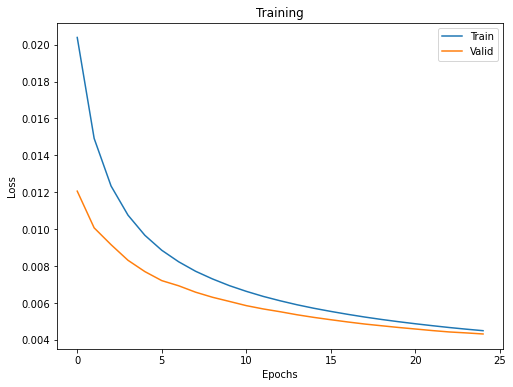

In [32]:
def plot(train_loss_epoch, val_loss_epoch):
    plt.figure(figsize = (8, 6))
    plt.plot(train_loss_epoch, label='Train')
    plt.plot(val_loss_epoch, label='Valid')

    plt.title('Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot(cnn_train_loss, cnn_val_loss)

**Продолжение д/з:**

- Обучите модель и постройте график падения ошибки.
- Выведите привычные картинки "до/после" автоэнкодера для нескольких объектов из test выборки (*подсказка:* с помощью ранее определенной функции `visualize`)

поменять
1. Такс, во-первых я не очень советую использовать unflatten тут
2. Как минимум, потому что он имеет ряд ограничений и неинтуитивен в использовании
Мне куда больше нравится писать x.view(<desired shape>) в forward

2. Во-вторых, свертки работают с квадратными матрицами. Конечно, они могут и с прямоугольными, но так не принято, потому что приходится следить за двумя размерностями, а преимущества никакого нет

3. В-третьих, существует некая традиция делать декодер в точности симметричным энкодеру. Она объясняется тем, что декодер должен обладать возможностями восстанавливать исходное изображение из латентного пространства. Это означает, что он должен обладать той же обобщающей способность, что и энкодер, а значит, иметь столько же весов

4. Таким образом, схема модели стандартно выглядит так: 
x -> encoder -> flatten -> linear down -> latent vector -> linear up -> unflatten -> decoder

5. Где два линейных слоя нужны только для того, чтобы привести латентный вектор к желаемому размеру

я переделал функцию для визауализации, потому что сделал без flatten обучение

In [83]:
# Функция для отрисовки оригинальных цифр, их представления и восстановленного рисунка
def visualize(img, model, div_coef=2):
    with torch.no_grad():
        x = img
        
        latent_code = model.encoder(x[None, :, :, :].to(DEVICE)).cpu()
        

        reco, _ = model(img[None, :, :, :].to(DEVICE))
        reco = reco[0].cpu()
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.permute(1, 2, 0))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(latent_code.reshape([latent_code.shape[-1]//div_coef,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1).permute(1, 2, 0))
    plt.show()

визуализация

Final MSE: 0.0043230983


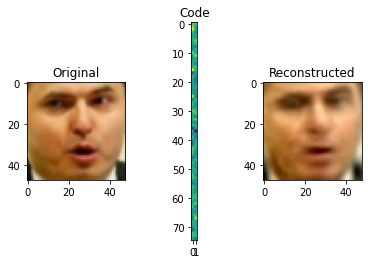

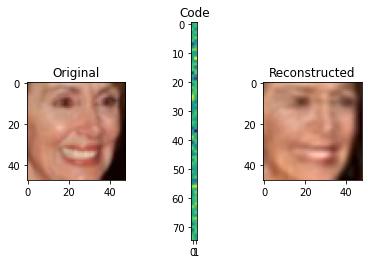

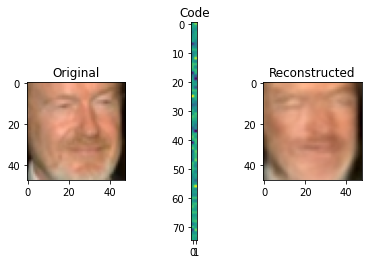

In [84]:
X_testtr = torch.tensor(X_test, dtype=torch.float32)
score = cnn_val_loss[-1]
print("Final MSE:",score)

for i in range(3):
    img = X_testtr[i]
    visualize(img, cnnmodel)